### Test github issue #3 
> pakiessling

In [1]:
from ELLA.ELLA import ELLA
import pandas as pd
import time
import pickle

In [2]:
def make_data_dict(expr, cell_seg):
    types = expr.type.unique()
    cells = expr.groupby("type")["cell"].agg(lambda x: list(set(x))).to_dict()
    cells_all = expr.cell.unique()
    genes = expr.groupby("type")["gene"].agg(lambda x: list(set(x))).to_dict() 
    data = {
        "types": types,
        "cells": cells,
        "cells_all": cells_all,
        "genes": genes, 
        "expr": expr,
        "cell_seg": cell_seg,
    }
    return data


expr = pd.read_parquet(
    "ella_experiment/ella_expr.parquet" # <<< jade
)
cell_seg = pd.read_parquet(
    "ella_experiment/ella_shapes.parquet" # <<< jade
)

In [3]:
# Only use CM cells
expr = expr[expr.type.isin(["CM"])].copy()
# expr.type.cat.remove_unused_categories(inplace=True)
expr['type'] = expr['type'].cat.remove_unused_categories() # <<<jade change this because of pandas version
print("Analyzing only CM cells")

Analyzing only CM cells


In [4]:
# Only use cells with at least X transcripts
min_transcripts = 1000
print(f"Filtering cells to at least {min_transcripts} transcripts")
expr = expr[expr.sc_total >= min_transcripts].copy()

cell_seg = cell_seg[cell_seg.cell.isin(expr.cell)]

expr['sc_total'] = expr['sc_total'].copy()

Filtering cells to at least 1000 transcripts


In [5]:
# Subsample from expr.cell values
cell_nr = 10 # <<< jade change from 200 to 10
print(f"Subsampling {cell_nr} cells")
random_values = cell_seg["cell"].drop_duplicates().sample(n=cell_nr, random_state=42)
cell_seg = cell_seg[cell_seg["cell"].isin(random_values)]
expr = expr[expr["cell"].isin(random_values)]

Subsampling 10 cells


In [6]:
# <<< jade
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from tqdm import tqdm
import matplotlib.patches as patches

The average number points per seg 502.0


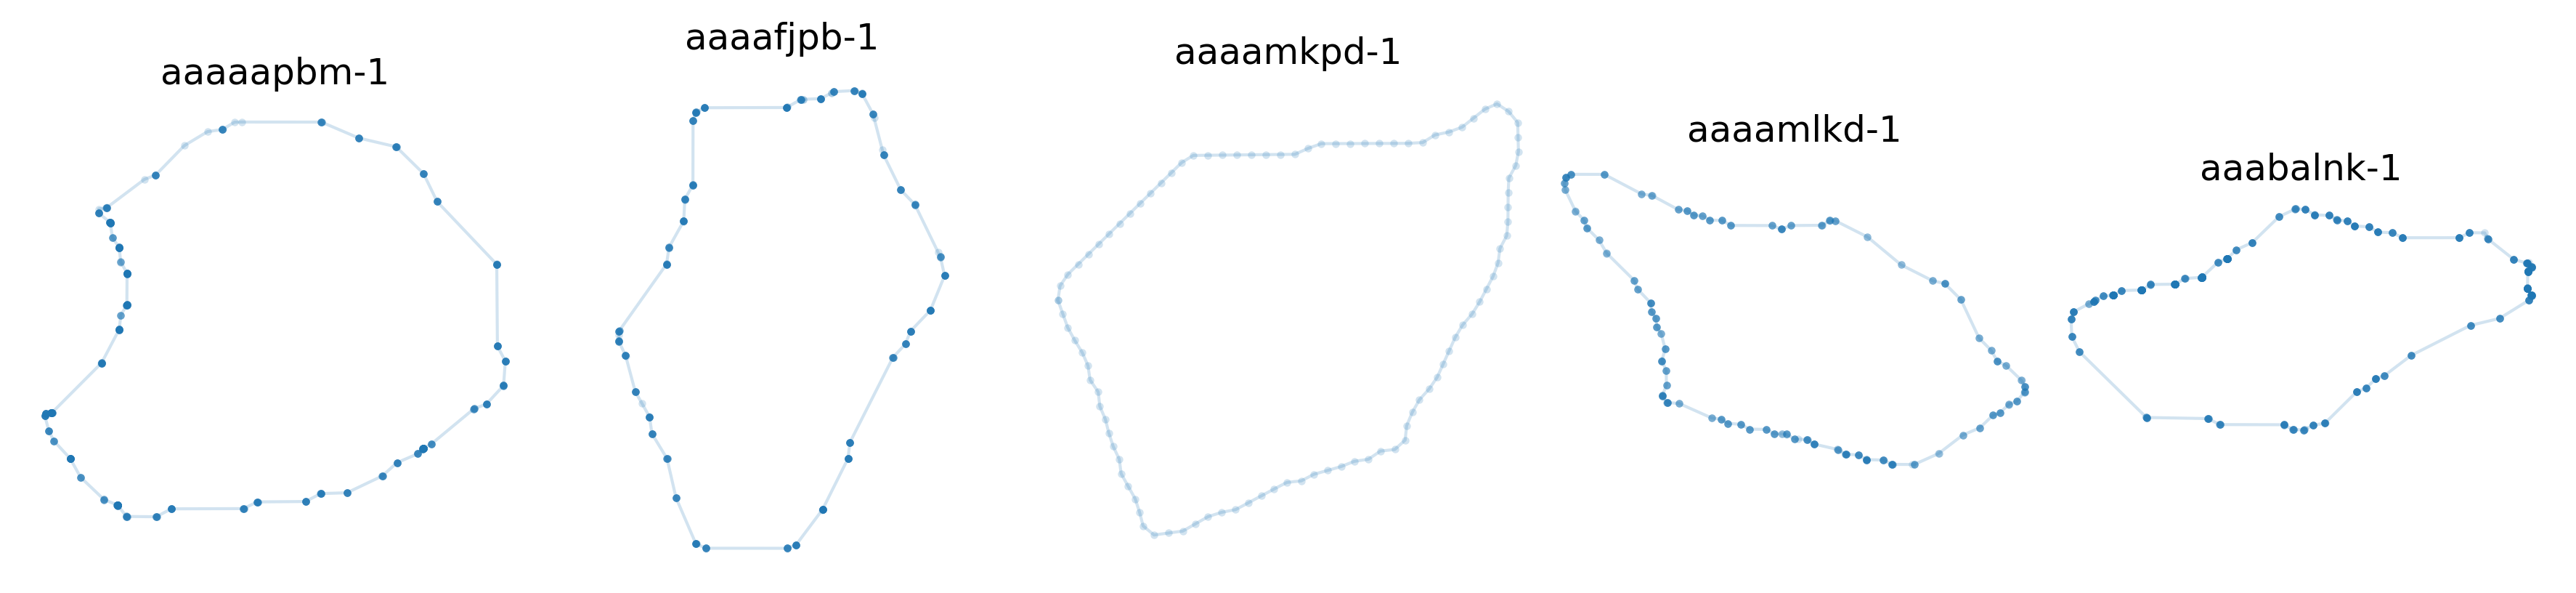

In [7]:
# <<< jade
# check current cell seg 
_cell_list = cell_seg.cell.unique()[:5]
seg_cl = cell_seg[cell_seg.cell.isin(_cell_list)]
print(f'The average number points per seg {seg_cl.groupby("cell").size().mean()}')

nr = 1
nc = len(_cell_list)
ss_nr = 3
ss_nc = 3
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr, nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
for i, c in enumerate(_cell_list):
    ax = plt.subplot(gs[0, i])
    seg_c = seg_cl[seg_cl.cell==c]
    ax.plot(seg_c.x, seg_c.y, marker='.', markersize=5, markeredgecolor='none', linewidth=1, alpha=0.2)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(c)
    ax.axis('off')

In [8]:
# <<< jade
# improve cell seg (augment num of points on boundary)
num_points = 100 # <<< input num of boundary points want to have
aug_points = []
cell_list = cell_seg.cell.unique()[:]
for i, c in enumerate(tqdm(cell_list)):
    seg_c = cell_seg[cell_seg.cell==c]
    cbound_shape = Polygon(list(zip(seg_c.x.values, seg_c.y.values))) # conver to shapely polygon
    more_points = [cbound_shape.boundary.interpolate(distance, normalized=True) for distance in np.linspace(0, 1, num_points)] # add more points
    points = [(point.x, point.y, c) for point in more_points]
    aug_points = aug_points + points
cell_seg_updated = pd.DataFrame(aug_points, columns=['x', 'y', 'cell'])
cell_seg_updated.head(2)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 146.73it/s]


,x,y,cell
0,13214.177406,2531.279176,aaaaapbm-1
1,13215.170015,2531.888318,aaaaapbm-1


The average number points per seg 100.0


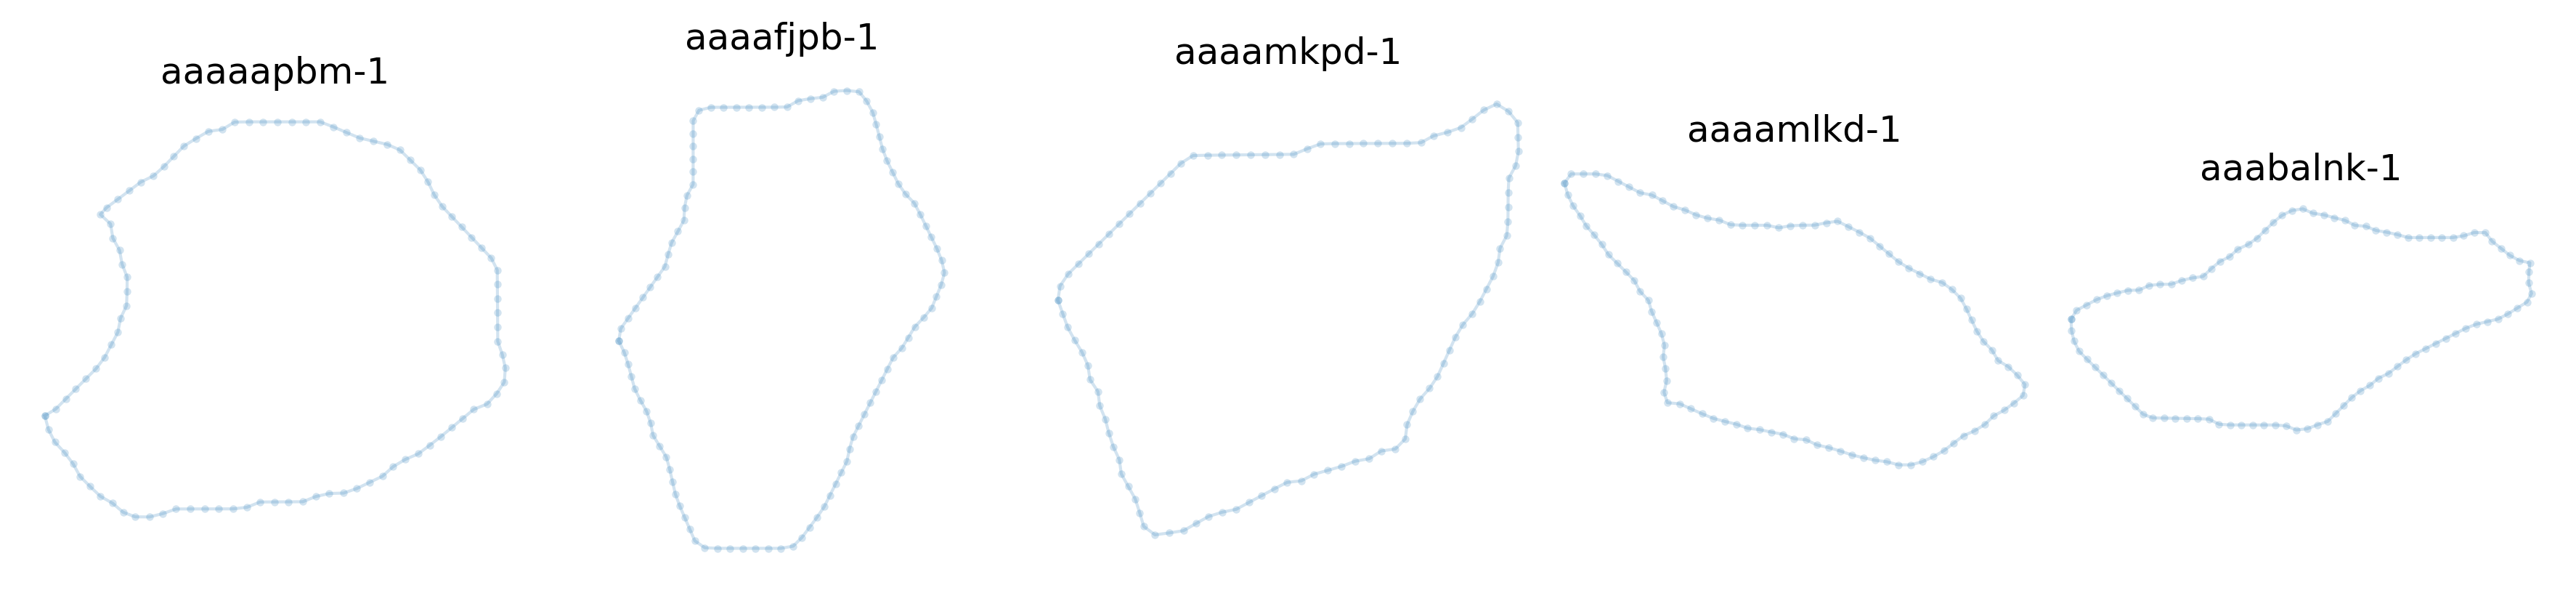

In [9]:
# <<< jade
# check updated cell seg 
_cell_list = cell_seg.cell.unique()[:5] 
seg_cl = cell_seg_updated[cell_seg_updated.cell.isin(_cell_list)]
print(f'The average number points per seg {seg_cl.groupby("cell").size().mean()}')

nr = 1
nc = len(_cell_list)
ss_nr = 3
ss_nc = 3
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr, nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)
for i, c in enumerate(_cell_list):
    ax = plt.subplot(gs[0, i])
    seg_c = seg_cl[seg_cl.cell==c]
    ax.plot(seg_c.x, seg_c.y, marker='.', markersize=5, markeredgecolor='none', linewidth=1, alpha=0.2)
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(c)
    ax.axis('off')

In [10]:
# <<< jade
# update cell_seg variable
cell_seg = cell_seg_updated
cell_seg.head(2)

,x,y,cell
0,13214.177406,2531.279176,aaaaapbm-1
1,13215.170015,2531.888318,aaaaapbm-1


In [11]:
assert len(set(expr.cell) - set(cell_seg.cell)) == 0, "Not all cells have a shape"

print(
    f"Number of cells: {cell_seg.cell.nunique()}, number of genes: {len(expr.gene.unique())}"
)

dd = make_data_dict(expr, cell_seg)

print(f"Length of types: {len(dd['types'])}")

# <<< jade include a few highly expressed genes
_NG = 20
dd['genes']['CM'] = expr.groupby('gene').size().sort_values(ascending=False).index.to_list()[:_NG]

Number of cells: 10, number of genes: 471
Length of types: 1


/tmp/ipykernel_1362579/472842118.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cells = expr.groupby("type")["cell"].agg(lambda x: list(set(x))).to_dict()
/tmp/ipykernel_1362579/472842118.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genes = expr.groupby("type")["gene"].agg(lambda x: list(set(x))).to_dict()
/tmp/ipykernel_1362579/3028227218.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dd['genes']['CM']

In [12]:
start = time.time()

ella = ELLA(
    dataset="test_run",
    adam_learning_rate_min=5e-2, # <<< jade
    adam_learning_rate_max=5e-2, # <<< jade
    max_iter=1000, # <<< jade
    hpp_solution = 'numerical' # <<< jade
)
ella.load_data(data_dict=dd)
print("Data loaded")
ella.register_cells()
print("Cells registered")
ella.nhpp_prepare()
ella.nhpp_fit()
print("NHPP fitted")
ella.weighted_density_est()
ella.compute_pv()

stop = time.time()
print(f"Run time: {stop - start}")
with open("ella_results.pkl", "wb") as f:
    pickle.dump(ella, f)

Number of cell types 1
Average number of genes 20.0
Average number of cells 10.0
Number of default kernels 22
Data loaded


Processing cells: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 18.34it/s]


Number of cells registered 10
Cells registered


NHPP fitting for CM: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [02:35<00:00,  7.76s/it]


NHPP fitted
Number of kernels in use 22
CM #sig=10
Run time: 156.39792251586914


array([6855.96533203, 6866.80566406, 6878.66894531, 6849.87988281,
       6765.82519531, 6723.98388672, 6719.85595703, 6719.85595703,
       6719.85595703, 6719.85595703, 6719.85595703, 6813.77441406,
       6817.70605469, 6820.03125   , 6811.93652344, 6773.83691406,
       6725.17089844, 6719.85595703, 6719.85595703, 6719.85595703,
       6719.85595703, 6719.85595703, 6719.85595703])

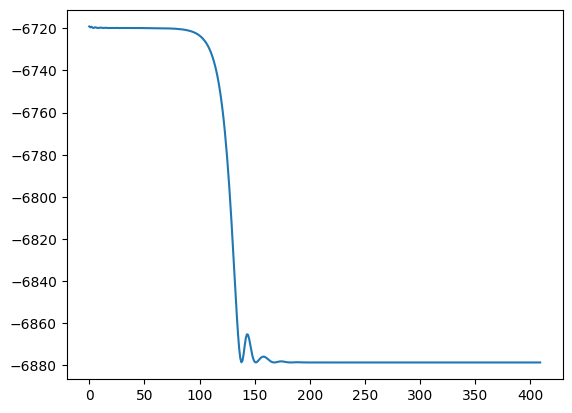

In [13]:
# <<< check convergence
loss = ella.loss_nhpp_dict['CM'][0][2]# [gene idx] [beta kernel index]
plt.plot(loss)

# ella.df_registered.head()
ella.mll_est['CM'][0,:]
# ella.A_est['CM'][0,:]
# ella.B_est['CM'][0,:]

93.0% positions within [0,1]


/tmp/ipykernel_1362579/1906349864.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gl = df.groupby('gene').size().sort_values(ascending=False).index.to_list() # sort genes based on expr counts


(array([ 7.,  8.,  2.,  4.,  4.,  6., 12., 10., 12., 15.]),
 array([0.2033505 , 0.28277302, 0.36219554, 0.44161806, 0.52104059,
        0.60046311, 0.67988563, 0.75930815, 0.83873067, 0.91815319,
        0.99757572]),
 <BarContainer object of 10 artists>)

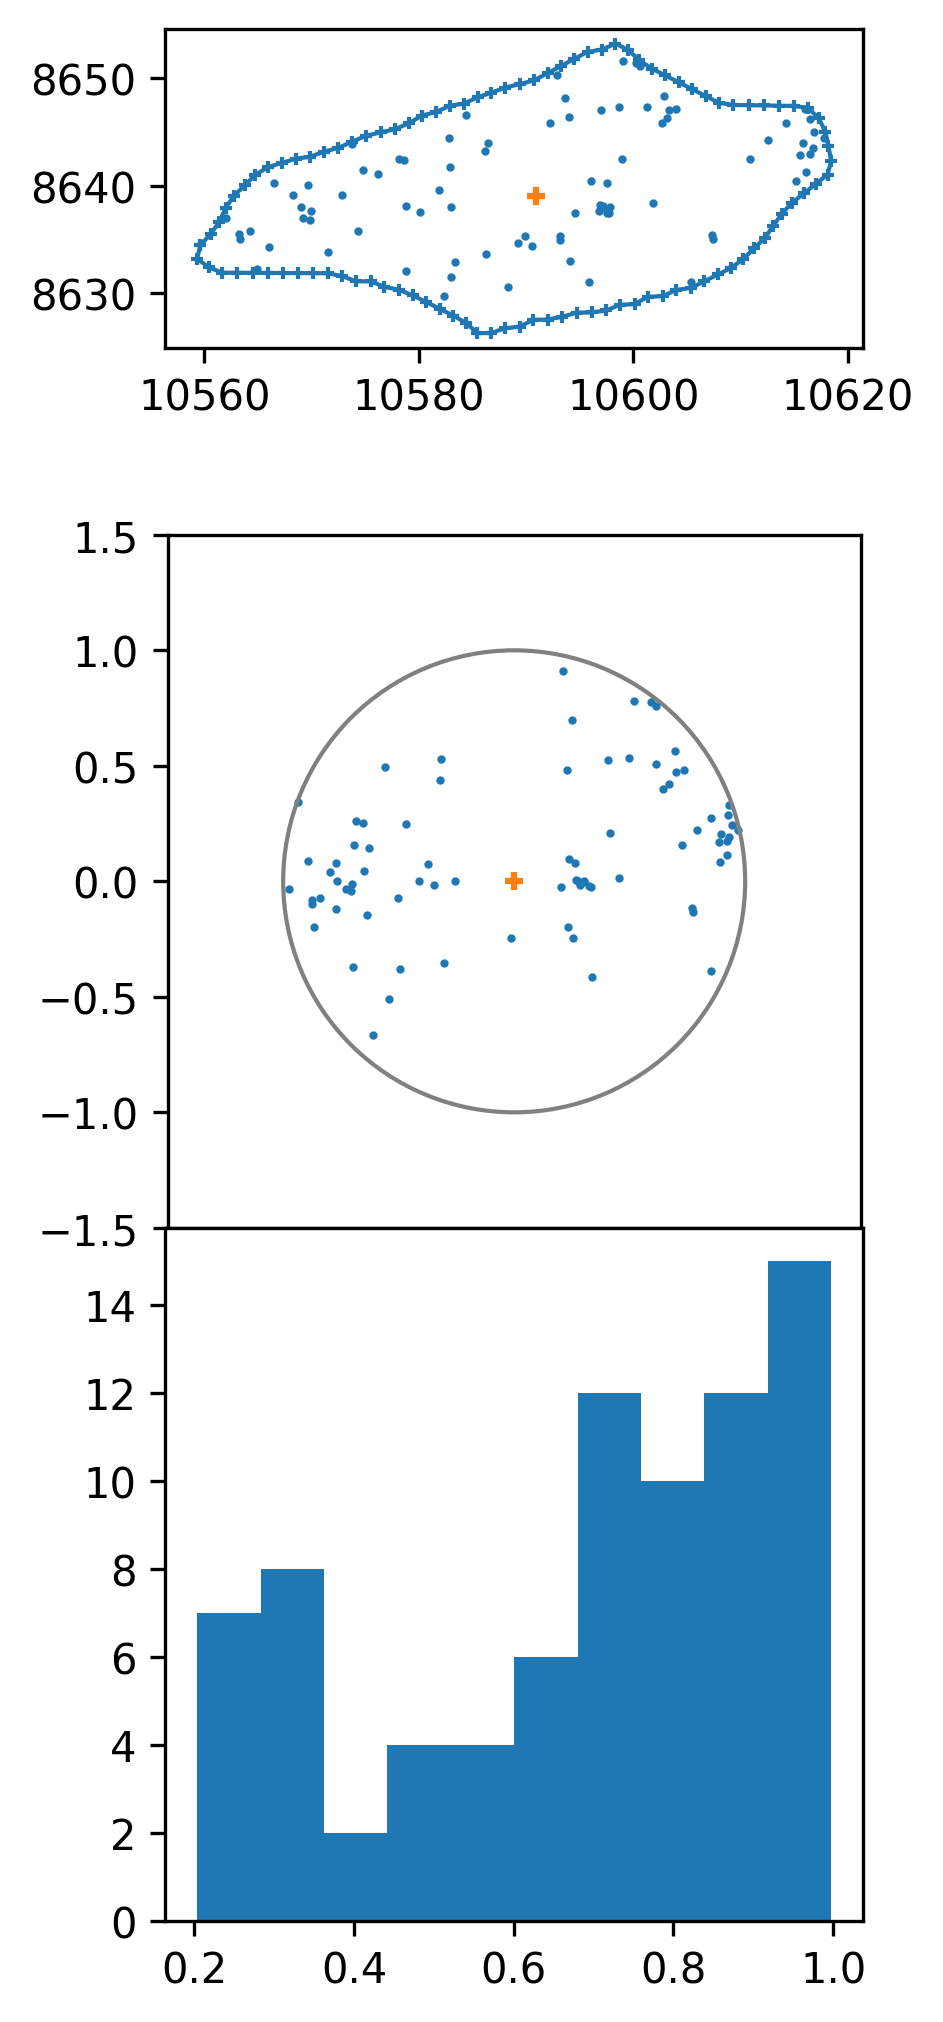

In [14]:
# <<< jade
# check registered cells with one cell and one gene

df = ella.df_registered.copy()
gl = df.groupby('gene').size().sort_values(ascending=False).index.to_list() # sort genes based on expr counts
c = 'aaabbnpj-1' # <<<
g = gl[0] # <<<

# get expr
df_cg = df[(df.cell==c)&(df.gene==g)]

# get cell seg
seg = ella.cell_mask_df.copy()
seg_c = seg[seg.cell==c]

nr = 3
nc = 1
ss_nr = 3
ss_nc = 3
fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
gs = fig.add_gridspec(nr, nc,
                      width_ratios=[1]*nc,
                      height_ratios=[1]*nr)
gs.update(wspace=0.0, hspace=0.0)

# original cell and expr
ax = plt.subplot(gs[0, 0])
ax.scatter(df_cg.x, df_cg.y, s=1)
ax.plot(seg_c.x, seg_c.y, marker='+', markersize=3, linewidth=1)
ax.scatter(df_cg.centerX.iloc[0], df_cg.centerY.iloc[0], marker='+', s=20)
ax.set_aspect('equal', adjustable='box')

# check the % of properly registered expressions
prop = np.sum((df_cg.d_c_s.values>=0)&(df_cg.d_c_s.values<=1))/len(df_cg)
print(f'{prop*100:.1f}% positions within [0,1]')

# registered cell and expr
ax = plt.subplot(gs[1, 0])
ax.scatter(df_cg.x_c_s, df_cg.y_c_s, s=1)
circle = patches.Circle((0, 0), radius=1, edgecolor='gray', facecolor='none', linewidth=1) 
ax.add_patch(circle)
ax.scatter(0, 0, marker='+', s=20)
ax.set_xlim([-1.5, 1.5])
ax.set_ylim([-1.5, 1.5])
ax.set_aspect('equal', adjustable='box')

# relative positions (normalized distances to cell center)
ax = plt.subplot(gs[2, 0])
d = df_cg.d_c_s
ax.hist(d[(d>=0)&(d<=1)])

The max number of clusters K=10
Pattern 1: 1 genes
Pattern 2: 1 genes
Pattern 3: 1 genes
Pattern 4: 2 genes
Pattern 5: 5 genes


/net/mulan/home/jadewang/tools/miniconda3/envs/ELLA/lib/python3.10/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (7) found smaller than n_clusters (8). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/net/mulan/home/jadewang/tools/miniconda3/envs/ELLA/lib/python3.10/site-packages/sklearn/base.py:1474: ConvergenceWarning: Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


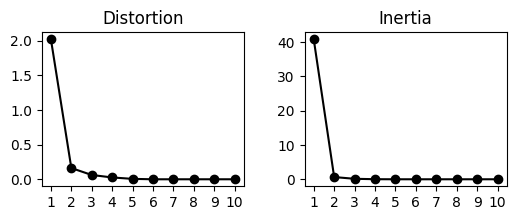

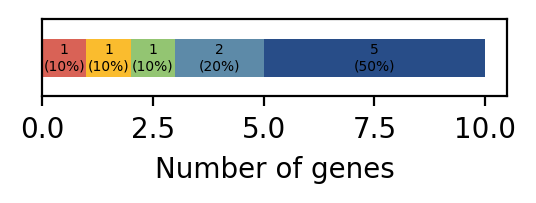

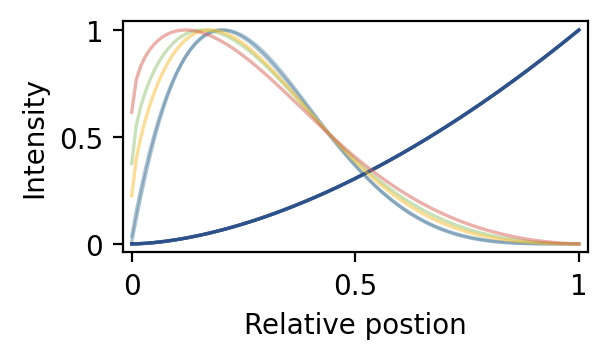

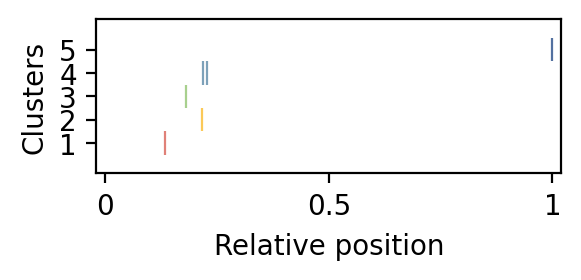

In [15]:
ella.pattern_clustering()
ella.pattern_labeling(K=5)

In [16]:
# detailed plots
# this is a temporary function
# every two rows corresponding to a gene
def detailed_plot_tmp(L):
    T = 'CM' # <<< cell type
    NG = 5 # <<< max num of genes to plot per pattern
    NC = 5 # <<< max num of cells to plot per gene
    cell_overlap = False # <<< overlay cells or not
    
    # get gene list and estimated patterns
    gl = np.array(ella.gene_list_dict[T])[ella.labels_dict[T]==L]
    p_fdr = np.array(ella.pv_fdr_tl[T])[ella.labels_dict[T]==L]
    lam = np.array(ella.weighted_lam_est[T])[ella.labels_dict[T]==L,:]
    pattern_strength = (np.max(lam, axis=1)-np.min(lam, axis=1))/(np.min(lam, axis=1)+1e-10)
    gl_sort = gl[np.argsort(pattern_strength)[::-1]] # sort gl based on pattern_strength
    
    # get expr
    df = ella.df_registered.copy()
    df_gl = df[df.gene.isin(gl_sort)]
    
    # get seg
    seg = ella.cell_mask_df
    
    # plot
    nr = np.minimum(NG, len(gl_sort))*2 # num of row of the plot
    if cell_overlap:
        nc = 2 # num of col of the plot
    else:
        nc = NC+1
    ss_nr = 3 # size of subplots
    ss_nc = 3 # size of subplots
    fig = plt.figure(figsize=(nc*ss_nc, nr*ss_nr), dpi=300)
    gs = fig.add_gridspec(nr, nc,
                          width_ratios=[1]*nc,
                          height_ratios=[1]*nr)
    gs.update(wspace=0.2, hspace=0.2)
    
    for i, g in enumerate(gl_sort):
        # ===== plot estimated pattern
        g_idx = np.where(gl==g)[0][0]
        lam_g = lam[g_idx,:]
        lam_g_std = (lam_g-np.min(lam_g))/(np.max(lam_g)-np.min(lam_g)+1e-10)
        # est lam std
        ax = plt.subplot(gs[i*2, 0]) 
        ax.plot(lam_g_std)
        ax.set_ylim([-0.02, 1.02])
        ax.set_xticks([1, len(lam_g_std)-1], [0,1])
        ax.set_title(g)
        ax.set_ylabel('lam est std')
        ax.text(len(lam_g)*0.5, 0.9, f'P={p_fdr[g_idx]:.3f}', fontsize=12, color='gray') # FDR corrected p-value
        ax.text(len(lam_g)*0.5, 0.8, f'Cluster={L}', fontsize=12, color='gray') # pattern cluster label
        ax.text(len(lam_g)*0.5, 0.7, f'Score={np.argmax(lam_g_std)/len(lam_g_std):.2f}', fontsize=12, color='gray') # pattern score
        ax.text(len(lam_g)*0.5, 0.6, f'PS={pattern_strength[g_idx]:.2f}', fontsize=12, color='gray') # pattern strength
        
        # raw est lam
        ax = plt.subplot(gs[i*2+1, 0]) 
        ax.plot(lam_g, color='gray')
        ax.set_ylim([0, np.max(lam_g)*1.02])
        ax.set_xticks([1, len(lam_g_std)-1], [0,1])
        ax.set_title(g)
        ax.set_ylabel('lam est')
    
        # ===== plot cells
        df_g = df_gl[df_gl.gene==g]
        cl = df_g.groupby('cell').size().sort_values(ascending=False).index.to_list()[:NC]
        for j, c in enumerate(cl):
            df_g_c = df_g[df_g.cell==c]
            seg_c = seg[seg.cell==c]
            # registered cell
            ax = plt.subplot(gs[i*2, j+1])
            ax.scatter(df_g_c.x_c_s, df_g_c.y_c_s, s=1)
            circle = patches.Circle((0, 0), radius=1, edgecolor='gray', facecolor='none', linewidth=1) 
            ax.add_patch(circle)
            ax.scatter(0, 0, marker='+', s=50, lw=1)
            ax.set_xlim([-1.1, 1.1])
            ax.set_ylim([-1.1, 1.1])
            ax.set_aspect('equal', adjustable='box')
            ax.axis('off')
            ax.set_title(c)
            # raw cell
            ax = plt.subplot(gs[i*2+1, j+1])
            ax.scatter(df_g_c.x, df_g_c.y, s=1)
            ax.plot(seg_c.x, seg_c.y, linewidth=1, color='gray')
            ax.scatter(df_g_c.centerX.iloc[0], df_g_c.centerY.iloc[0], marker='+', s=50, lw=1)
            ax.set_aspect('equal', adjustable='box')        
            ax.axis('off')
            ax.set_title(c)

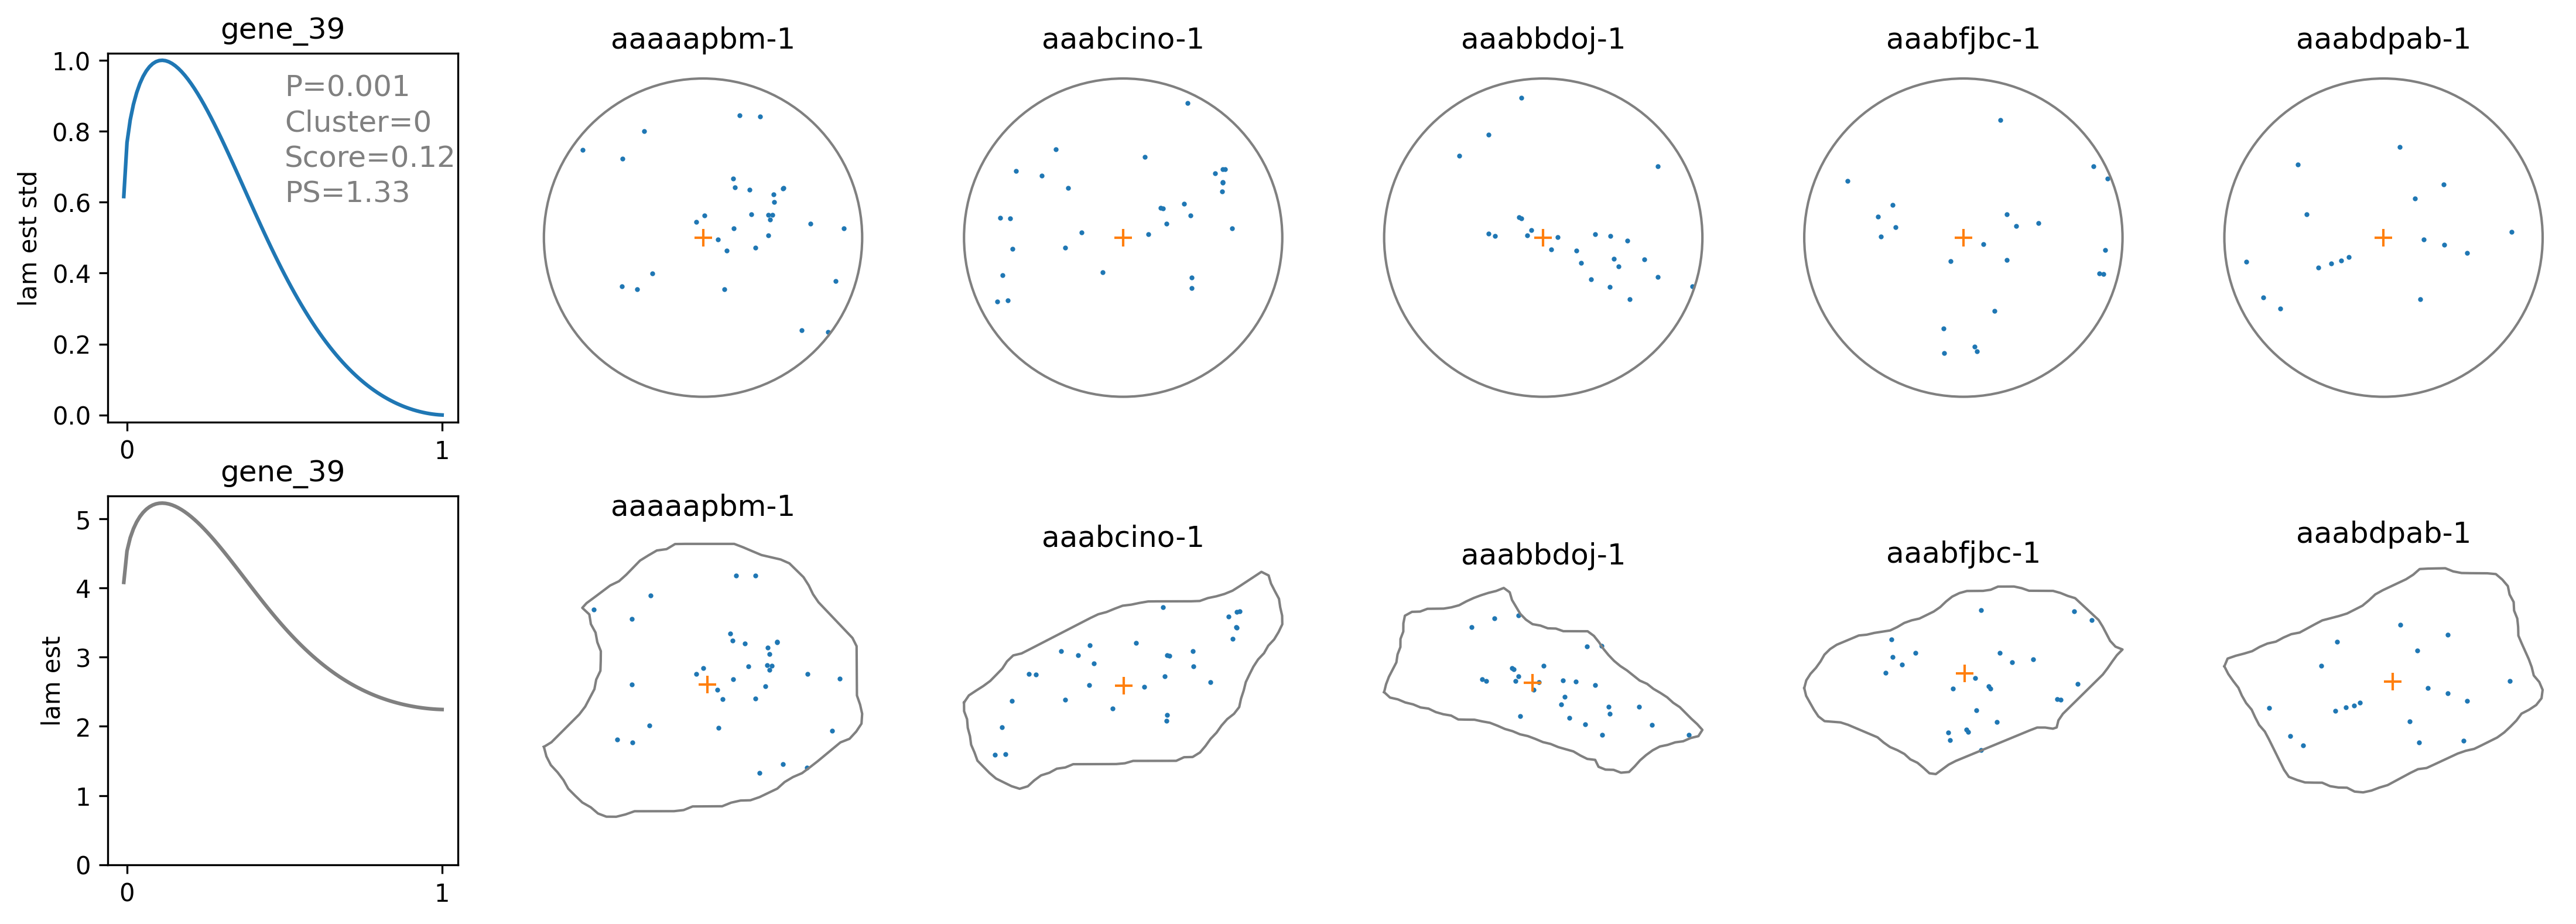

In [17]:
# gene and cells in Pattern Cluster 0
detailed_plot_tmp(L=0)

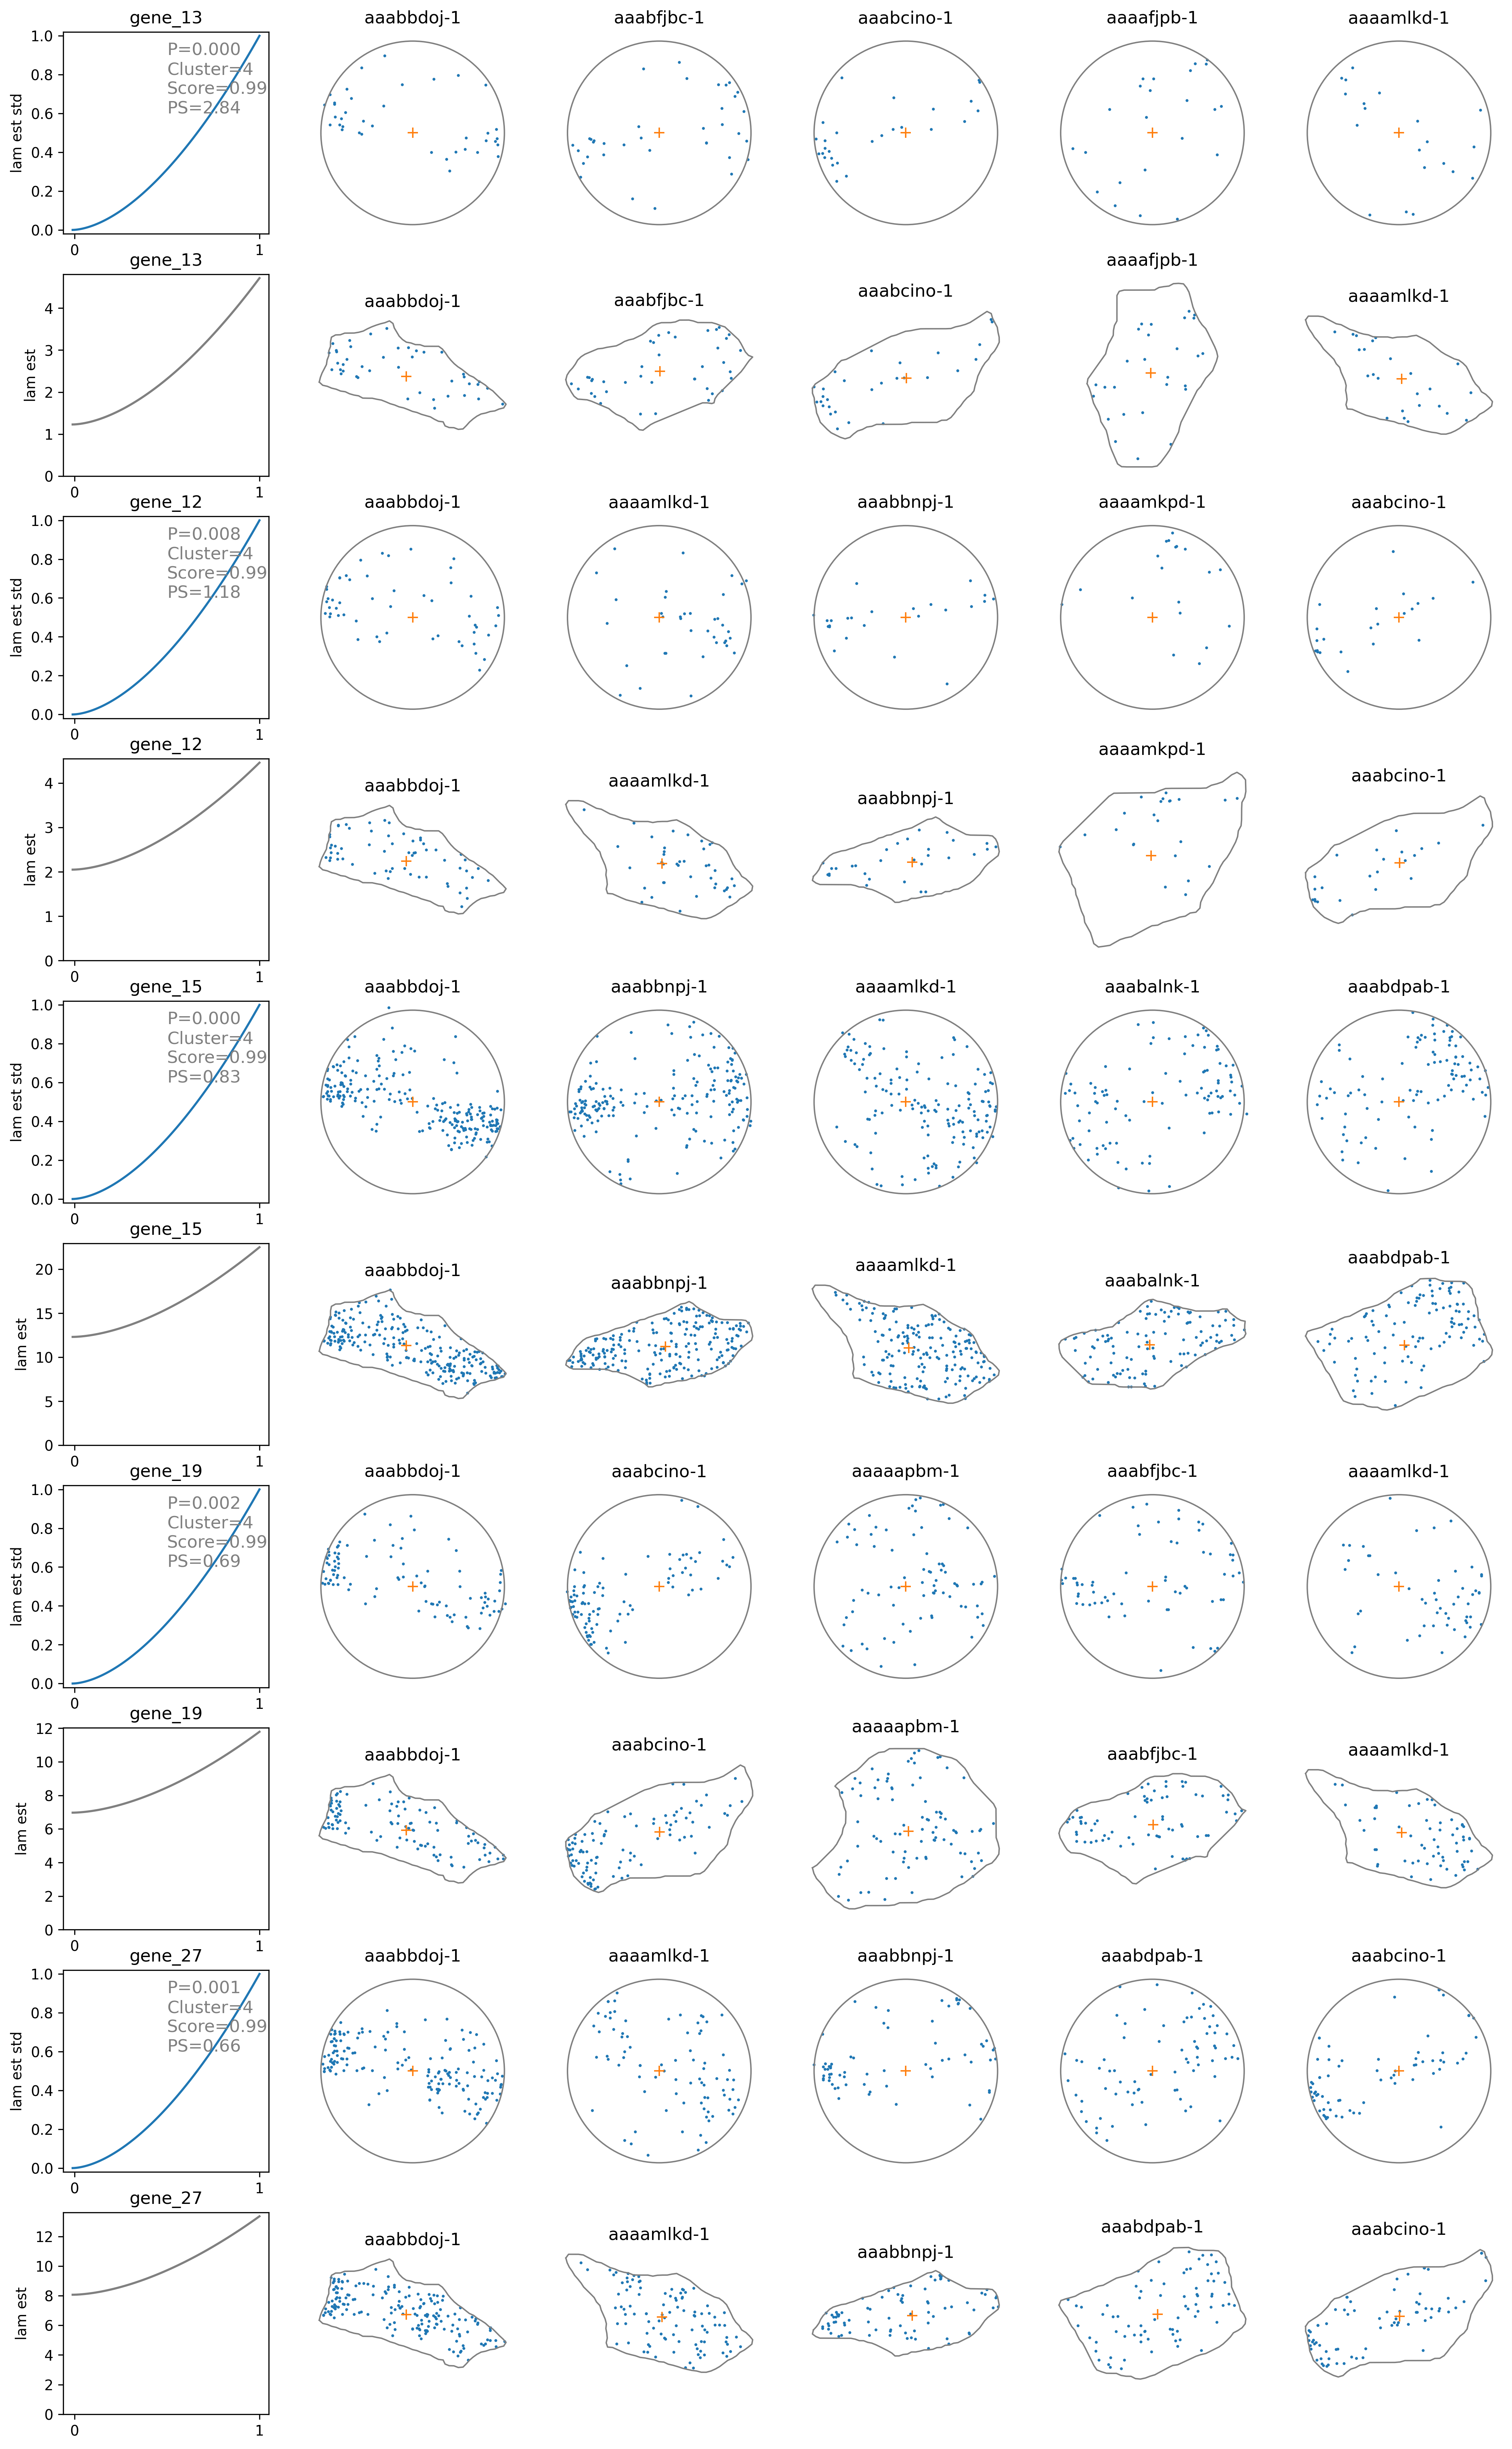

In [18]:
# gene and cells in Pattern Cluster 4
detailed_plot_tmp(L=4)